Задача кредитного скоринга возникает в банках и других кредитных организациях при принятии решений о выдаче кредитов. Задача заключается в том, чтобы на основе некоторой информации о заявителе обоснованно принять решение — стоит ли ему выдавать кредит, и если да, то на каких условиях. 
+ Необходимо провести разведочный анализ данных (EDA) 
+ Придумать новые признаки на основе предложенных данных + поэкспериментировать с различными моделями машинного обучения,
+ сделать с помощью этих моделей прогноз на тестовом датасете 
+ загрузить ответы на страницу с результатами.

# Установка пакетов

In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.6 MB/s eta 0:00:00


# Загрузка библиотек

In [3]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split 
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from catboost import cv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# Загрузка данных

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SHIFT/Data/Intensiv_2023/v1/train.csv')

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/SHIFT/Data/Intensiv_2023/v1/test.csv')

In [ ]:
bki = pd.read_csv('/content/drive/MyDrive/SHIFT/Data/Intensiv_2023/v2/bki.csv')

In [ ]:
sample_answ = pd.read_csv('/content/drive/MyDrive/SHIFT/Data/Intensiv_2023/v1/sample_answer.csv')

In [ ]:
df.head(3)

,reco_id_curr,target,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,...,document_18_flag,document_19_flag,document_20_flag,document_21_flag,requests_bki_hour,requests_bki_day,requests_bki_week,requests_bki_month,requests_bki_qrt,requests_bki_year
0,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
1,214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0


In [ ]:
test.head(3)

,reco_id_curr,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,goods_price,...,document_18_flag,document_19_flag,document_20_flag,document_21_flag,requests_bki_hour,requests_bki_day,requests_bki_week,requests_bki_month,requests_bki_qrt,requests_bki_year
0,100008,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
1,100017,Cash loans,M,Y,N,1,225000.0,918468.0,28966.5,697500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,100019,Cash loans,M,Y,Y,0,157500.0,299772.0,20160.0,247500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
sample_answ.head(3)

,reco_id_curr,target
0,100008,0.5
1,100017,0.5
2,100019,0.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261384 entries, 0 to 261383
Columns: 122 entries, reco_id_curr to requests_bki_year
dtypes: float64(65), int64(41), object(16)
memory usage: 243.3+ MB


# EDA

**Имеем дисбаланс целевого признака**

## Определение категор и числовых признаков

In [ ]:
numerical_features = []
categorical_features = []
target = []

In [ ]:
numerical_features = []
categorical_features = []
target = []
for column in df.columns:
    if df[column].dtype == 'object':
      categorical_features.append(column)
    elif column == 'target':
      target.append(column)       
    else:
        numerical_features.append(column)

In [ ]:
print('Кол-во категорильных:', len(categorical_features))
print('Кол-во числовых:',len(numerical_features))
print('Таргет:', len(target))

Кол-во категорильных: 16
Кол-во числовых: 105
Таргет: 1


In [ ]:
df[categorical_features].head(3)

,contract_type_name,gender,own_car_flag,own_realty_flag,type_suite_name,income_type_name,education_type_name,family_status_name,housing_type_name,type_of_occupation,start_weekday_appr_process,type_of_organization,fondkapremon_mode,mode_house_type,mode_walls_material,emergency_state_mode
0,Cash loans,M,Y,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,THURSDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
1,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,Managers,THURSDAY,Business Entity Type 3,reg oper account,block of flats,Monolithic,No
2,Cash loans,F,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,TUESDAY,Self-employed,NaN,NaN,NaN,NaN


## ML

### Разбиение данных

In [ ]:
train, valid = train_test_split(df, test_size=0.25, random_state=12)

In [ ]:
print(train.shape)
print(valid.shape)

(196038, 122)
(65346, 122)


### Определение признаков

In [ ]:
features_train = train.drop('target', axis=1)
target_train = train['target']
features_valid = valid.drop('target', axis=1)
target_valid = valid['target']

In [ ]:
print(f'Размероность features_train: {features_train.shape}')
print(f'Размероность target_train: {target_train.shape}')
print(f'Размероность features_valid: {features_valid.shape}')
print(f'Размероность target_valid: {target_valid.shape}')

Размероность features_train: (196038, 121)
Размероность target_train: (196038,)
Размероность features_valid: (65346, 121)
Размероность target_valid: (65346,)


### Подготовка признаков

#### Категориальных

In [ ]:
features_train[categorical_features] = features_train[categorical_features].astype('str')
features_valid[categorical_features] = features_valid[categorical_features].astype('str')
test[categorical_features] = test[categorical_features].astype('str')

#### Числовых

In [ ]:
scaler = StandardScaler()

In [ ]:
'''features_train_scaled = features_train.copy()
target_train_scaled = target_train.copy()
features_valid_scaled = features_valid.copy()
target_valid_scaled = target_valid.copy()
test_scaled = test.copy()'''

'features_train_scaled = features_train.copy()\ntarget_train_scaled = target_train.copy()\nfeatures_valid_scaled = features_valid.copy()\ntarget_valid_scaled = target_valid.copy()\ntest_scaled = test.copy()'

In [ ]:
'''scaler.fit(features_train[numerical_features])'''

'scaler.fit(features_train[numerical_features])'

In [ ]:
'''features_train_scaled[numerical_features] =  scaler.transform(features_train[numerical_features])
target_train_scaled = np.array(target_train)
features_valid_scaled[numerical_features] = scaler.transform(features_valid[numerical_features])
target_valid_scaled = np.array(target_valid)
test_scaled[numerical_features] = scaler.transform(test[numerical_features])'''

'features_train_scaled[numerical_features] =  scaler.transform(features_train[numerical_features])\ntarget_train_scaled = np.array(target_train)\nfeatures_valid_scaled[numerical_features] = scaler.transform(features_valid[numerical_features])\ntarget_valid_scaled = np.array(target_valid)\ntest_scaled[numerical_features] = scaler.transform(test[numerical_features])'

In [ ]:
'''features_train_scaled = pd.DataFrame(features_train_scaled, index = features_train.index, columns = features_train.columns)
features_valid_scaled = pd.DataFrame(features_valid_scaled, index = features_valid.index, columns = features_valid.columns)
test_scaled = pd.DataFrame(test_scaled, index = test.index, columns = test.columns)'''

'features_train_scaled = pd.DataFrame(features_train_scaled, index = features_train.index, columns = features_train.columns)\nfeatures_valid_scaled = pd.DataFrame(features_valid_scaled, index = features_valid.index, columns = features_valid.columns)\ntest_scaled = pd.DataFrame(test_scaled, index = test.index, columns = test.columns)'

### Разработка модели

#### Установка гиперпараметров

In [ ]:
Catboost = CatBoostClassifier(random_state = 12,
                              verbose=50,
                              scale_pos_weight = 12,
                              custom_loss = 'AUC',
                              iterations=150,
                              learning_rate=0.2,
                              depth = 5,
                              l2_leaf_reg = 4
                              )

In [ ]:
cat_features = categorical_features

#### Обучение

In [ ]:
Catboost.fit(features_train, target_train,
             cat_features = cat_features,
             eval_set=(features_valid, target_valid))

0:	learn: 0.6721471	test: 0.6719497	best: 0.6719497 (0)	total: 342ms	remaining: 51s
50:	learn: 0.5874560	test: 0.5924714	best: 0.5924714 (50)	total: 13.5s	remaining: 26.2s
100:	learn: 0.5706509	test: 0.5854922	best: 0.5854329 (97)	total: 26.2s	remaining: 12.7s
149:	learn: 0.5579220	test: 0.5851708	best: 0.5850879 (121)	total: 40.7s	remaining: 0us

bestTest = 0.5850879015
bestIteration = 121

Shrink model to first 122 iterations.


## Предсказание и оценка качества

In [ ]:
predict = Catboost.predict(test)
print(predict)

[0 0 1 ... 1 1 0]


In [ ]:
predict_probability = Catboost.predict_proba(test)[:, 1]
print(predict_probability)

[0.47892532 0.27866164 0.50935372 ... 0.66948872 0.55220975 0.416838  ]


In [ ]:
auc_roc = metrics.roc_auc_score(target_valid, Catboost.predict_proba(features_valid)[:, 1])

print(auc_roc)

0.7583059962324478


roc_auc-best = 0.76151

```
# Выбран кодовый формат
```



roc_auc_scaled_feat = 0.5666132601027234

roc_auc = 0.7560301695695976

# Загрузка результатов

In [ ]:
sample_answ['target'] = predict_probability

In [ ]:
sample_answ.head()

,reco_id_curr,target
0,100008,0.478925
1,100017,0.278662
2,100019,0.509354
3,100022,0.189132
4,100023,0.364499


In [ ]:
'''sample_answ.to_csv('/content/drive/MyDrive/SHIFT/Data/Intensiv_2023/answer.csv', index = False)
print('Файл сохранен на гугл-диске')'''

"sample_answ.to_csv('/content/drive/MyDrive/SHIFT/Data/Intensiv_2023/answer.csv', index = False)\nprint('Файл сохранен на гугл-диске')"

# Интерпретация работы модели

Выведем с помощью дата-фрема значимость признаков. Чем выше значимость - тем выше корреляция с target. 

                        features  feature_importance
42             external_source_3           21.576870
41             external_source_2           13.446410
40             external_source_1            7.512264
16                    days_birth            5.747395
7                      loan_body            5.344897
9                    goods_price            4.913321
8                annuity_payment            3.747424
17                 days_employed            3.300648
12           education_type_name            2.350785
19         publication_timestamp            1.901542
2                         gender            1.645122
94      last_phone_number_change            1.378885
39          type_of_organization            1.260567
30   rating_client_w_city_region            1.046520
96               document_3_flag            1.005574
1             contract_type_name            0.922815
3                   own_car_flag            0.901273
18        registration_timestamp            0.

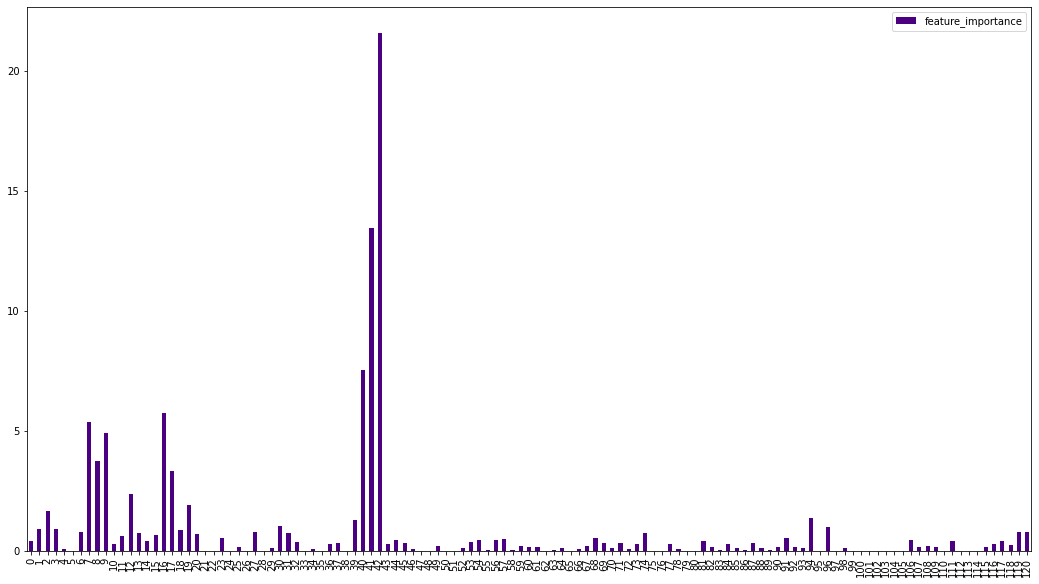

In [ ]:
feature_importances = pd.DataFrame({'features': test.columns,'feature_importance':Catboost.feature_importances_})
print(feature_importances.sort_values('feature_importance',ascending=False).head(25))
'''#plot(feature importance)
importance = Catboost.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()'''
feature_importances.plot(kind='bar', figsize=(18,10), color='indigo')

# Получение сильных признаков

Получим список самых значисых признаков, значимость которых больше 1%.

In [ ]:
features_best = feature_importances.query('feature_importance > 1')['features']

## Значения признаков

+ contract_type_name - Идентификация, если заём выдается наличными или по кредитной карте
+ loan_body - сумма займа
+ goods_price -Для POS-займов это цена товара, на который оформляется заём
+ days_birth - Возраст клиента в днях на момент оформления займа
+ days_employed - За сколько дней до оформления займа человек начал текущую работу
+ publication_timestamp - За сколько дней до оформления займа изменился документ, с помощью которого клиент проходил идентификацию
+ age_own_car - Возраст автомобиля клиента
+ type_of_occupation - Профессия клиента
+ external_source - Нормализованный балл из внешнего источника данных(скор клиента)
+ median_years_beginexpluatation - Нормализованная информация о здании, в котором живет клиент(лет)
+ last_phone_number_change - За сколько дней до оформления текущего займа клиент сменил телефон
+ document_3_flag - Предоставил ли клиент документ 3
+ requests_bki_qrt - Количество запросов в БКИ о клиенте за 3 месяца до оформления займа

 # Предобрабортка df

In [ ]:
df[features_best].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261384 entries, 0 to 261383
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   gender                       261384 non-null  object 
 1   loan_body                    261384 non-null  float64
 2   annuity_payment              261373 non-null  float64
 3   goods_price                  261152 non-null  float64
 4   education_type_name          261384 non-null  object 
 5   days_birth                   261384 non-null  int64  
 6   days_employed                261384 non-null  int64  
 7   publication_timestamp        261384 non-null  int64  
 8   rating_client_w_city_region  261384 non-null  int64  
 9   type_of_organization         261384 non-null  object 
 10  external_source_1            113996 non-null  float64
 11  external_source_2            260825 non-null  float64
 12  external_source_3            209684 non-null  float64
 13 

**Типы данных в норме**

## Обработка пропусков

In [ ]:
df[features_best].isna().mean()

gender                         0.000000
loan_body                      0.000000
annuity_payment                0.000042
goods_price                    0.000888
education_type_name            0.000000
days_birth                     0.000000
days_employed                  0.000000
publication_timestamp          0.000000
rating_client_w_city_region    0.000000
type_of_organization           0.000000
external_source_1              0.563875
external_source_2              0.002139
external_source_3              0.197793
last_phone_number_change       0.000004
document_3_flag                0.000000
dtype: float64

Заполним пропуски в признаке annuity_payment рассчетом с помощью признака loan_body, умножив его на среднее значение отношения df_1['annuity_payment'] / df_1['loan_body'].

In [ ]:
df['annuity_payment'] = df['annuity_payment'].fillna(df['loan_body'] * ((df['annuity_payment']/df['loan_body']).mean()))

Пропуски в признаке цена товара, заполним суммой выданного кредита:

In [ ]:
df['goods_price'] = df['goods_price'].fillna(df['loan_body'])

Пропуски в признаке age_own_car говорят нам о том,что вероятно у клиента нет автомобиля. Заполним пропуски групповым большим числом, например 100.

In [ ]:
df['age_own_car'] = df['age_own_car'].fillna(100)

Создадим новый признак, показывающий безработный или работающимй человек.

In [ ]:
def set_professia(type_of_organisation, type_of_occupation):
  if type_of_organisation == 'XNA':
     type_of_occupation = 'Unemployed'
  else: 
    type_of_occupation ='Worker'

  return type_of_occupation

df['work_status'] = df.apply(lambda x: set_professia(x['type_of_organization'], x['type_of_occupation']), axis=1)

In [ ]:
df['work_status'].value_counts()

Worker        214280
Unemployed     47104
Name: work_status, dtype: int64

Признаки external_source - это скор клиента из БКИ. Отсутствующие значения - это отсутсвие информации, заполним их значением "нет"

In [ ]:
df['external_source_1'] = df['external_source_1'].fillna(0)
df['external_source_2'] = df['external_source_2'].fillna(0)
df['external_source_3'] = df['external_source_3'].fillna(0)
print('кол-во пропусков external_source_1:', df['external_source_1'].isna().mean())
print('кол-во пропусков external_source_2 :', df['external_source_2'].isna().mean())
print('кол-во пропусков external_source_3:', df['external_source_3'].isna().mean())

кол-во пропусков external_source_1: 0.0
кол-во пропусков external_source_2 : 0.0
кол-во пропусков external_source_3: 0.0


Пропуски в признаке median_years_beginexpluatation заполним самым часто встречающимся значением.

In [ ]:
df['median_years_beginexpluatation'] = df['median_years_beginexpluatation'].fillna(0.98)
print('кол-во пропусков median_years_beginexpluatation:', df['median_years_beginexpluatation'].isna().mean())

кол-во пропусков median_years_beginexpluatation: 0.0


Пропуски в признаке last_phone_number_change заполняем самым часто стречающимся значением.

In [ ]:
df['last_phone_number_change'] = df['last_phone_number_change'].fillna(0)
print('кол-во пропусков last_phone_number_change:', df['last_phone_number_change'].isna().mean())

кол-во пропусков last_phone_number_change: 0.0


Пропуски в признаке requests_bki_qrt означают, очевидно, что запросов в БКИ не было. Заполним их нулями.

In [ ]:
df['requests_bki_qrt'] =  df['requests_bki_qrt'].fillna(0)
print('кол-во пропусков requests_bki_qrt:', df['requests_bki_qrt'].isna().mean())

кол-во пропусков requests_bki_qrt: 0.0


## Исключение выбросов

In [ ]:
t = df.query('days_birth > days_employed')

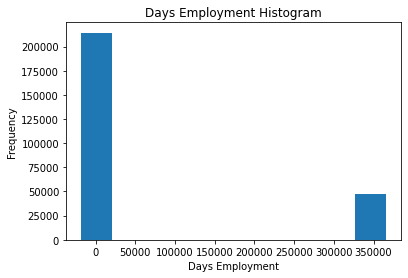

In [ ]:
df['days_employed'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Видим большое число выбросов одинакового значения. Их примерно 20%. Создадим новый признак  - это будет флаг наличия аномального опыта.

In [ ]:
df['days_employed_anom'] = df["days_employed"] == 365243

Сам выброс заменим на медианное значение.

In [ ]:
df['days_employed'].replace({365243: -1647.0}, inplace = True)

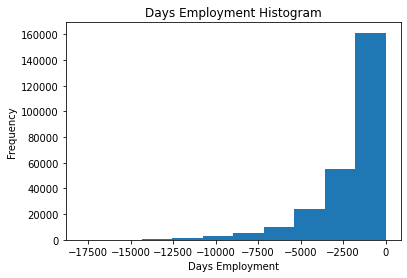

In [ ]:
df['days_employed'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

# Предобработка test

### Предобработка пропусков

In [ ]:
test[features_best].isna().mean()

gender                         0.000000
loan_body                      0.000000
annuity_payment                0.000022
goods_price                    0.000997
education_type_name            0.000000
days_birth                     0.000000
days_employed                  0.000000
publication_timestamp          0.000000
rating_client_w_city_region    0.000000
type_of_organization           0.000000
external_source_1              0.563444
external_source_2              0.002190
external_source_3              0.200858
last_phone_number_change       0.000000
document_3_flag                0.000000
dtype: float64

Заполним пропуски в признаке annuity_payment рассчетом с помощью признака loan_body, умножив его на среднее значение отношения test['annuity_payment'] / test['loan_body'].

In [ ]:
test['annuity_payment'] = test['annuity_payment'].fillna(test['loan_body'] * ((test['annuity_payment']/test['loan_body']).mean()))

Пропуски в признаке цена товара, заполним суммой выданного кредита:

In [ ]:
test['goods_price'] = test['goods_price'].fillna(test['loan_body'])

Пропуски в признаке age_own_car говорят нам о том,что вероятно у клиента нет автомобиля. Заполним пропуски групповым большим числом, например 100.

In [ ]:
test['age_own_car'] = test['age_own_car'].fillna(100)

Создадим новый признак, показывающий безработный или работающимй человек.

In [ ]:
def set_professia(type_of_organisation, type_of_occupation):
  if type_of_organisation == 'XNA':
     type_of_occupation = 'Unemployed'
  else: 
    type_of_occupation ='Worker'

  return type_of_occupation

test['work_status'] = test.apply(lambda x: set_professia(x['type_of_organization'], x['type_of_occupation']), axis=1)

In [ ]:
test['work_status'].value_counts()

Worker        37857
Unemployed     8270
Name: work_status, dtype: int64

Признаки external_source - это скор клиента из БКИ. Отсутствующие значения - это отсутсвие информации, т.е 0.

In [ ]:
test['external_source_1'] = test['external_source_1'].fillna(0)
test['external_source_2'] = test['external_source_2'].fillna(0)
test['external_source_3'] = test['external_source_3'].fillna(0)
print('кол-во пропусков external_source_1:', test['external_source_1'].isna().mean())
print('кол-во пропусков external_source_2 :', test['external_source_2'].isna().mean())
print('кол-во пропусков external_source_3:', test['external_source_3'].isna().mean())

кол-во пропусков external_source_1: 0.0
кол-во пропусков external_source_2 : 0.0
кол-во пропусков external_source_3: 0.0


In [ ]:
test['median_years_beginexpluatation'] = test['median_years_beginexpluatation'].fillna(0.98)
print('кол-во пропусков median_years_beginexpluatation:', test['median_years_beginexpluatation'].isna().mean())

кол-во пропусков median_years_beginexpluatation: 0.0


In [ ]:
test['last_phone_number_change'] = test['last_phone_number_change'].fillna(0)
print('кол-во пропусков last_phone_number_change:', test['last_phone_number_change'].isna().mean())

кол-во пропусков last_phone_number_change: 0.0


In [ ]:
test['requests_bki_qrt'] =  test['requests_bki_qrt'].fillna(0)
print('кол-во пропусков requests_bki_qrt:', test['requests_bki_qrt'].isna().mean())

кол-во пропусков requests_bki_qrt: 0.0


## Исключение выбросов

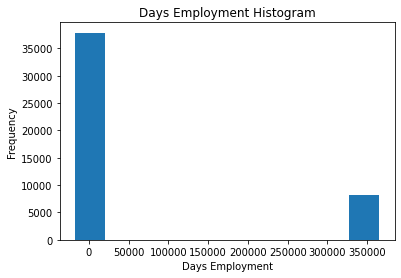

In [ ]:
test['days_employed'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
test['days_employed_anom'] = df["days_employed"] == 365243

In [ ]:
test['days_employed'].replace({365243: -1647.0}, inplace = True)

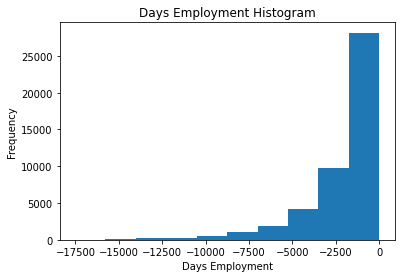

In [ ]:
test['days_employed'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

# Заполнение пропусков остальных признаков

#### Заполнение пропусков отстальных признаков

Выведем рейтинг признаков с самой высокой долей пропусков:

In [ ]:
df.isna().mean().sort_values(ascending=False).head(50)

mode_commonarea                    0.698884
median_commonarea                  0.698884
average_commonarea                 0.698884
non_living_apartments_mode         0.694492
non_living_apartments_avg          0.694492
non_living_apartments_medi         0.694492
fondkapremon_mode                  0.684059
median_living_apartments           0.683814
mode_living_apartments             0.683814
average_living_apartments          0.683814
mode_min_floors                    0.678802
average_min_floors                 0.678802
median_min_floors                  0.678802
average_years_building             0.665309
mode_years_building                0.665309
median_years_building              0.665309
mode_land_area                     0.593816
average_land_area                  0.593816
median_land_area                   0.593816
median_basementarea                0.585070
mode_basementarea                  0.585070
average_basementarea               0.585070
non_living_area_medi            

Самая высокая доля пропусков у признаков характеризующих жилье заемщика. Очевидно, что пропуски присутствуют у клиентов, которые не владеют жильем. Можно заполнить их групповым значением "Отсутствует". Всего их 46.

In [ ]:
housing_features = list(
    df.isna().mean().
    sort_values(ascending=False).
    head(46).
    reset_index()['index']
    )

In [ ]:
df[housing_features] = df[housing_features].fillna(-1)
test[housing_features] = test[housing_features].fillna(-1)

Следующая группа признаков с пропусками - это количесиво запросов в БКИ. Пропуски - отсутствие запросов. Заполним значением 0.

In [ ]:
requests_bki_features = ['requests_bki_year', 'requests_bki_month', 'requests_bki_week', 'requests_bki_day', 'requests_bki_hour']

In [ ]:
df[requests_bki_features] = df[requests_bki_features].fillna(0)
test[requests_bki_features] = test[requests_bki_features].fillna(0)

Узнаем, какие признаки с пропусками у нас остались:

In [ ]:
df.isna().mean().sort_values(ascending=False).head(7)

type_of_occupation                 0.313573
type_suite_name                    0.004124
observes_60_count_social_circle    0.003332
social_circle_defaults_60_days     0.003332
observes_30_count_social_circle    0.003332
social_circle_defaults_30_days     0.003332
family_members__count              0.000008
dtype: float64

In [ ]:
df['type_of_occupation'] = df['type_of_occupation'].astype(str)
test['type_of_occupation'] = test['type_of_occupation'].astype(str)
print('Пропуски в type_of_occupation:', df['type_of_occupation'].isna().mean())
print('Пропуски в type_of_occupation:', test['type_of_occupation'].isna().mean())

Пропуски в type_of_occupation: 0.0
Пропуски в type_of_occupation: 0.0


In [ ]:
df['type_suite_name'] = df['type_suite_name'].astype(str).replace('nan', 'Unaccompanied')
test['type_suite_name'] = test['type_suite_name'].astype(str).replace('nan', 'Unaccompanied')
print('Пропуски в type_suite_name:', df['type_suite_name'].isna().mean())
print('Пропуски в type_suite_name:', test['type_suite_name'].isna().mean())

Пропуски в type_suite_name: 0.0
Пропуски в type_suite_name: 0.0


In [ ]:
delays_features = ['social_circle_defaults_60_days', 'observes_60_count_social_circle',
                   'observes_30_count_social_circle', 'social_circle_defaults_30_days']

In [ ]:
df[delays_features] = df[delays_features].fillna(0)
test[delays_features] = test[delays_features].fillna(0)
print('Пропуски в delays_features:', df[delays_features].isna().mean())
print('Пропуски в delays_features:', test[delays_features].isna().mean())

Пропуски в delays_features: social_circle_defaults_60_days     0.0
observes_60_count_social_circle    0.0
observes_30_count_social_circle    0.0
social_circle_defaults_30_days     0.0
dtype: float64
Пропуски в delays_features: social_circle_defaults_60_days     0.0
observes_60_count_social_circle    0.0
observes_30_count_social_circle    0.0
social_circle_defaults_30_days     0.0
dtype: float64


In [ ]:
df['family_members__count'] = df['family_members__count'].fillna(1)
test['family_members__count'] = test['family_members__count'].fillna(1)
print('Пропуски в family_members__count:', df['family_members__count'].isna().mean())
print('Пропуски в family_members__count:', test['family_members__count'].isna().mean())

Пропуски в family_members__count: 0.0
Пропуски в family_members__count: 0.0


# Предсказание на преобработанном дата-сете

Создадим функцию для предсказания:

In [ ]:
def predict_func(train_, test):
  numerical_features = []
  categorical_features = []
  for column in train_.columns:
    if train_[column].dtype == 'object':
      categorical_features.append(column)     
    else:
        numerical_features.append(column)
  #############     
  train, valid = train_test_split(train_, test_size=0.25, random_state=12)
  #############
  features_train = train.drop('target', axis=1)
  target_train = train['target']
  features_valid = valid.drop('target', axis=1)
  target_valid = valid['target']
  ############
  features_train[categorical_features] = features_train[categorical_features].astype('str')
  features_valid[categorical_features] = features_valid[categorical_features].astype('str')
  test[categorical_features] = test[categorical_features].astype('str')
  ###########
  Catboost = CatBoostClassifier(random_state = 12,
                              verbose=50,
                              scale_pos_weight = 12,
                              custom_loss = 'AUC',
                              iterations=200,
                              learning_rate=0.2,
                              depth = 5,
                              l2_leaf_reg = 4)
  cat_features = categorical_features
  ###########
  Catboost.fit(features_train, target_train, cat_features = cat_features, eval_set=(features_valid, target_valid))
  predict_probability = Catboost.predict_proba(test)[:, 1]
  auc_roc = metrics.roc_auc_score(target_valid, Catboost.predict_proba(features_valid)[:, 1])
  return print('AUC_ROC:', auc_roc)

Определим качество предсказаний после заполнения пропусков самых сильных признаков:

In [ ]:
predict_func(df, test)

**Качество предсказаний улучшилось незначительно.**

## Предсказание только на самых сильных обработанных признаках

In [ ]:
df[features_best].columns

Index(['gender', 'loan_body', 'annuity_payment', 'goods_price',
       'education_type_name', 'days_birth', 'days_employed',
       'publication_timestamp', 'rating_client_w_city_region',
       'type_of_organization', 'external_source_1', 'external_source_2',
       'external_source_3', 'last_phone_number_change', 'document_3_flag'],
      dtype='object')

In [ ]:
df_best_features = df[['gender', 'loan_body', 'annuity_payment', 'goods_price',
       'education_type_name', 'days_birth', 'days_employed',
       'publication_timestamp', 'rating_client_w_city_region',
       'type_of_organization', 'external_source_1', 'external_source_2',
       'external_source_3', 'last_phone_number_change', 'document_3_flag', 'target']]
test_best_features = test[features_best]

In [ ]:
predict_func(df_best_features, test_best_features)

**Результат не изменился. Значит остальные признаки не влияют на работу модели.**

## Предсказание на чистом дата-сете

In [ ]:
predict_func(df, test)

**Качество предсказаний на чистых дата-сетах не улучшилось.**

# Создание новых признаков

+ процент суммы кредита относительно дохода клиента
+ процент аннуитетного платежа кредита относительно дохода клиента
+ продолжительность платежа в месяцах
+ процент отработанных дней по отношению к возрасту клиента

In [ ]:
df['credit_sum__income_part'] = df['income'] / df['loan_body']
test['credit_sum__income_part'] = test['income'] / test['loan_body']

In [ ]:
df['payment_part_annuity'] = df['annuity_payment'] / df['income']
test['payment_part_annuity'] = test['annuity_payment'] / test['income']

In [ ]:
df['duration_credit'] = df['loan_body'] / df['annuity_payment']
test['duration_credit'] = test['loan_body'] / test['annuity_payment']

In [ ]:
df['spent_part'] = df['days_employed'] / df['days_birth']
test['spent_part'] = test['days_employed'] / test['days_birth']

 Предскажем с добавленными признаками:

In [ ]:
predict_func(df, test)

**Создание новых признаков улучшило результаты на примерно на 0,5%**

# Присоединение нового дата-сета

In [ ]:
bki.sort_values(by='reco_id_curr').head(4)

,Unnamed: 0,reco_id_curr,reco_bureau_id,credit_status,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,credit_limit_max_overdue,credit_prolong_count,credit_sum,credit_sum_debt,credit_sum_limit,credit_sum_overdue,credit_type,days_credit_update,annuity_payment
248487,248487,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248485,248485,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248490,248490,100001,5896636,Active,currency 1,-320,0,411.0,NaN,NaN,0,168345.0,110281.5,NaN,0.0,Consumer credit,-10,9364.5
248489,248489,100001,5896635,Active,currency 1,-49,0,1778.0,NaN,NaN,0,378000.0,373239.0,0.0,0.0,Consumer credit,-16,10822.5


In [ ]:
bki[bki['reco_id_curr'] == 100002]

,Unnamed: 0,reco_id_curr,reco_bureau_id,credit_status,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,credit_limit_max_overdue,credit_prolong_count,credit_sum,credit_sum_debt,credit_sum_limit,credit_sum_overdue,credit_type,days_credit_update,annuity_payment
675684,675684,100002,6158904,Closed,currency 1,-1125,0,-1038.0,-1038.0,NaN,0,40761.000,NaN,NaN,0.0,Credit card,-1038,0.0
675685,675685,100002,6158905,Closed,currency 1,-476,0,NaN,-48.0,NaN,0,0.000,0.0,NaN,0.0,Credit card,-47,NaN
675686,675686,100002,6158906,Closed,currency 1,-1437,0,-1072.0,-1185.0,0.000,0,135000.000,0.0,0.000,0.0,Consumer credit,-1185,0.0
675687,675687,100002,6158907,Closed,currency 1,-1121,0,-911.0,-911.0,3321.000,0,19071.000,NaN,NaN,0.0,Consumer credit,-906,0.0
675688,675688,100002,6158908,Closed,currency 1,-645,0,85.0,-36.0,5043.645,0,120735.000,0.0,0.000,0.0,Consumer credit,-34,0.0
675689,675689,100002,6158909,Active,currency 1,-103,0,NaN,NaN,40.500,0,31988.565,0.0,31988.565,0.0,Credit card,-24,0.0
1337779,1337779,100002,6158903,Active,currency 1,-1042,0,780.0,NaN,NaN,0,450000.000,245781.0,0.000,0.0,Consumer credit,-7,0.0
1486113,1486113,100002,6113835,Closed,currency 1,-1043,0,62.0,-967.0,0.000,0,67500.000,NaN,NaN,0.0,Credit card,-758,0.0


In [ ]:
df[df['reco_id_curr'] == 100002]

,reco_id_curr,target,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,...,requests_bki_week,requests_bki_month,requests_bki_qrt,requests_bki_year,work_status,days_employed_anom,credit_sum__income_part,payment_part_annuity,duration_credit,spent_part
17677,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,Worker,False,0.498036,0.121978,16.461104,0.067329


In [ ]:
df.sort_values(by='reco_id_curr')

,reco_id_curr,target,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,...,requests_bki_week,requests_bki_month,requests_bki_qrt,requests_bki_year,work_status,days_employed_anom,credit_sum__income_part,payment_part_annuity,duration_credit,spent_part
17677,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,Worker,False,0.498036,0.121978,16.461104,0.067329
140587,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,Worker,False,0.208736,0.132217,36.234085,0.070862
12943,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,Worker,False,0.500000,0.100000,20.000000,0.011814
195574,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,Worker,False,0.431748,0.219900,10.532818,0.159905
91683,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,Worker,False,0.236842,0.179963,23.461618,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208926,456249,0,Cash loans,F,N,Y,0,112500.0,225000.0,22050.0,...,0.0,2.0,0.0,0.0,Unemployed,True,0.500000,0.196000,10.204082,0.067544
181487,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,0.0,Unemployed,True,0.267112,0.166687,22.459693,0.079278
114106,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,1.0,0.0,1.0,Worker,False,0.225776,0.195941,22.604623,0.529266
207594,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0.0,Worker,False,0.462029,0.118158,18.317595,0.400134


In [ ]:
df_1 = df.merge(bki, on='reco_id_curr', how='left')

In [ ]:
test_1 = test.merge(bki, on ='reco_id_curr', how='left')

In [ ]:
df_1

,reco_id_curr,target,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment_x,...,days_enddate_fact,credit_limit_max_overdue,credit_prolong_count,credit_sum,credit_sum_debt,credit_sum_limit,credit_sum_overdue,credit_type,days_credit_update,annuity_payment_y
0,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,-1036.0,NaN,0.0,19453.5,0.0,NaN,0.0,Consumer credit,-1033.0,37305.0
1,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,NaN,NaN,0.0,49374.0,0.0,NaN,0.0,Consumer credit,-610.0,0.0
2,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,-1036.0,NaN,0.0,19449.0,0.0,0.0,0.0,Consumer credit,-906.0,0.0
3,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,NaN,NaN,0.0,405000.0,276988.5,0.0,0.0,Consumer credit,-12.0,NaN
4,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,-225.0,0.0,0.0,225000.0,0.0,0.0,0.0,Consumer credit,-225.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283238,291070,0,Cash loans,F,N,N,1,112500.0,315000.0,15151.5,...,-932.0,0.0,0.0,59400.0,0.0,0.0,0.0,Consumer credit,-932.0,0.0
1283239,291070,0,Cash loans,F,N,N,1,112500.0,315000.0,15151.5,...,-1645.0,NaN,0.0,209308.5,NaN,NaN,0.0,Consumer credit,-1645.0,NaN
1283240,291070,0,Cash loans,F,N,N,1,112500.0,315000.0,15151.5,...,-1247.0,NaN,0.0,96615.0,0.0,NaN,0.0,Consumer credit,-1247.0,NaN
1283241,291070,0,Cash loans,F,N,N,1,112500.0,315000.0,15151.5,...,-1175.0,NaN,0.0,180000.0,NaN,NaN,0.0,Consumer credit,-1175.0,NaN


In [ ]:
numerical_features = []
categorical_features = []
for column in df_1.columns:
    if df_1[column].dtype == 'object':
        categorical_features.append(column)     
    else:
        numerical_features.append(column)
  #############     
train, valid = train_test_split(df_1, test_size=0.25, random_state=12)
  #############
features_train = train.drop('target', axis=1)
target_train = train['target']
features_valid = valid.drop('target', axis=1)
target_valid = valid['target']
  ############
features_train[categorical_features] = features_train[categorical_features].astype('str')
features_valid[categorical_features] = features_valid[categorical_features].astype('str')
test_1[categorical_features] = test_1[categorical_features].astype('str')
  ###########
Catboost = CatBoostClassifier(random_state = 12,
                              verbose=50,
                              scale_pos_weight = 12,
                              custom_loss = 'AUC',
                              iterations=250,
                              learning_rate=0.2,
                              depth = 5,
                              l2_leaf_reg = 4)
cat_features = categorical_features
  ###########
Catboost.fit(features_train, target_train, cat_features = cat_features, eval_set=(features_valid, target_valid))
predict_probability_1 = Catboost.predict_proba(test_1)[:, 1]
auc_roc = metrics.roc_auc_score(target_valid, Catboost.predict_proba(features_valid)[:, 1])
print('AUC_ROC:', auc_roc)

0:	learn: 0.6679823	test: 0.6681248	best: 0.6681248 (0)	total: 3.47s	remaining: 14m 23s
50:	learn: 0.5571514	test: 0.5564810	best: 0.5564810 (50)	total: 2m 43s	remaining: 10m 38s
100:	learn: 0.5253579	test: 0.5221736	best: 0.5221736 (100)	total: 5m 22s	remaining: 7m 55s
150:	learn: 0.5082048	test: 0.5060062	best: 0.5060062 (150)	total: 8m	remaining: 5m 14s
200:	learn: 0.4931180	test: 0.4918405	best: 0.4918405 (200)	total: 10m 38s	remaining: 2m 35s
249:	learn: 0.4817970	test: 0.4822024	best: 0.4822024 (249)	total: 13m 14s	remaining: 0us

bestTest = 0.4822024057
bestIteration = 249

AUC_ROC: 0.8551145421347607


AUC_ROC: 0.8551145421347607

In [ ]:
sample_answ['target'] = predict_probability_1

ValueError: ignored

In [ ]:
sample_answ.head()

,reco_id_curr,target
0,100008,0.478925
1,100017,0.278662
2,100019,0.509354
3,100022,0.189132
4,100023,0.364499


In [ ]:
'''sample_answ.to_csv('/content/drive/MyDrive/SHIFT/Data/Intensiv_2023/answer.csv', index = False)
print('Файл сохранен на гугл-диске')'''

"sample_answ.to_csv('/content/drive/MyDrive/SHIFT/Data/Intensiv_2023/answer.csv', index = False)\nprint('Файл сохранен на гугл-диске')"